In [104]:
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import sent_tokenize
import re
import numpy as np
import matplotlib.pyplot as plt
import gensim

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

In [41]:
notebook_dir = os.getcwd()
rel_path = '../../data/complete_data/minutes_cleaned_spy_tnx.csv'

df=pd.read_csv(os.path.join(notebook_dir, rel_path), parse_dates=['date'])
df['contents'] = df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
df

In [43]:
# Add a key for aggregation
df['key'] = df.index.get_level_values(0)

,date,contents,speaker,title,cleaned content,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+8,SPY: d+9,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,^TNX: d-1,^TNX: d+0,key
0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.228840,26.228840,...,25.353941,25.335722,25.317480,25.408628,25.499771,25.481544,25.809616,6.46,6.45,0
1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",26.242849,26.297777,26.297777,26.462597,26.316092,...,25.839960,25.968145,25.894901,25.986456,25.949821,26.316092,26.371048,5.96,5.91,1
2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.876577,25.858253,26.389338,26.462597,26.224543,...,26.499214,26.755606,26.718981,26.627411,26.535858,26.444292,26.206207,6.07,6.15,2
3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",26.096867,26.170630,26.465714,26.539474,26.521048,...,26.391937,26.465714,26.447271,26.262850,26.391937,26.539474,26.521048,5.80,5.80,3
4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",26.779240,26.871473,27.019003,27.019003,27.037449,...,27.295633,27.406303,27.480083,27.443203,27.350977,27.369425,27.184990,5.68,5.70,4


# Split the data by sentence, to perform sentiment analysis on short texts

In [45]:
def split_df(df, text_column='contents'):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = sent_tokenize(row[text_column])
        for text in text_list:
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    
    split_df = pd.DataFrame(split_data_list, columns=df.columns.tolist()+['text','word_count'])

    return split_df
df_for_keys = split_df(df)
print(df_for_keys.shape)

/var/folders/z_/5fj7_z3n12dg5t3n8g2f7mzc0000gn/T/ipykernel_48022/228543081.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm(df.iterrows(), total=df.shape[0]):


  0%|          | 0/240 [00:00<?, ?it/s]

(43915, 26)


# Download Bert for sentiment analysis

In [48]:
import torch
# Load a BERT model, which was trained by another Financial Texts
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.eval()
model.to("cpu")

Downloading: 100%|██████████| 570/570 [00:00<00:00, 924kB/s]
Downloading: 100%|██████████| 420M/420M [01:08<00:00, 6.46MB/s] 
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFor

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Predict sentiment for every sentence
### Define Encoder, Model and Prediction functions

In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

Downloading: 100%|██████████| 226k/226k [00:00<00:00, 624kB/s] 
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 20.1kB/s]


In [50]:
def predict(text, model):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
    Returns
    -------
        pred : Prediction vector
    """        
    text_ids, pad_masks, segment_ids = bert_encoder(text)
    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    
    return pred

In [51]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text,model)

array([[0.40291947, 0.30661672, 0.29046375]], dtype=float32)

In [52]:
def score_text(df, text_column, model):
    class_names = ['Negative', 'Neutral', 'Positive']
    scores = []
    predicts = []
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        score = predict(row[text_column], model)
        scores.append((score[0]))
        predicts.append(class_names[int(np.argmax(score))])

    df['score'] = scores
    df['prediction'] = predicts
    
    return df

### Run Prediction

In [53]:
result_df = pd.DataFrame([], columns=df_for_keys.columns)
train_sample = df_for_keys
res = score_text(train_sample, 'text', model)
result_df = pd.concat([result_df, res], axis=0)

result_df.head()

/var/folders/z_/5fj7_z3n12dg5t3n8g2f7mzc0000gn/T/ipykernel_48022/2272131318.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm(df.iterrows(), total=df.shape[0]):


  0%|          | 0/43915 [00:00<?, ?it/s]

,date,contents,speaker,title,cleaned content,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+12,SPY: d+13,SPY: d+14,^TNX: d-1,^TNX: d+0,key,text,word_count,score,prediction
0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,25.499771,25.481544,25.809616,6.46,6.45,0,A meeting of the Federal Open Market Committee...,70,"[0.42016122, 0.35652682, 0.22331198]",Negative
1,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,25.499771,25.481544,25.809616,6.46,6.45,0,"Broaddus, Jordan, Forrestal, and Parry, Altern...",13,"[0.39067277, 0.3409824, 0.26834482]",Negative
2,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,25.499771,25.481544,25.809616,6.46,6.45,0,"Hoenig, Melzer, and Syron, Presidents of the F...",18,"[0.4103146, 0.32946816, 0.2602173]",Negative
3,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,25.499771,25.481544,25.809616,6.46,6.45,0,"Kohn, Secretary and Economist Mr. Berna...",31,"[0.39506024, 0.3518381, 0.25310162]",Negative
4,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,25.499771,25.481544,25.809616,6.46,6.45,0,"R. Davis, Lang, Lindsey, Promisel, Rose...",13,"[0.40811267, 0.3455379, 0.24634944]",Negative


In [54]:
result_df.prediction.value_counts()

Negative    42207
Neutral      1677
Positive       31
Name: prediction, dtype: int64

In [55]:
result_df = pd.concat([result_df, pd.get_dummies(result_df['prediction'])], axis=1)

,date,contents,speaker,title,cleaned content,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,^TNX: d-1,^TNX: d+0,key,text,word_count,score,prediction,Negative,Neutral,Positive
0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,6.46,6.45,0,A meeting of the Federal Open Market Committee...,70,"[0.42016122, 0.35652682, 0.22331198]",Negative,1,0,0
1,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,6.46,6.45,0,"Broaddus, Jordan, Forrestal, and Parry, Altern...",13,"[0.39067277, 0.3409824, 0.26834482]",Negative,1,0,0
2,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,6.46,6.45,0,"Hoenig, Melzer, and Syron, Presidents of the F...",18,"[0.4103146, 0.32946816, 0.2602173]",Negative,1,0,0
3,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,6.46,6.45,0,"Kohn, Secretary and Economist Mr. Berna...",31,"[0.39506024, 0.3518381, 0.25310162]",Negative,1,0,0
4,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.22884,26.22884,...,6.46,6.45,0,"R. Davis, Lang, Lindsey, Promisel, Rose...",13,"[0.40811267, 0.3455379, 0.24634944]",Negative,1,0,0


In [56]:
train_result = df.copy()
train_result['key2'] =  "_" + train_result['key'].map(str)
result_df['key2'] = "_" + result_df['key'].map(str)

neg = result_df.groupby(by=['key2'])['Negative'].sum()
neu = result_df.groupby(by=['key2'])['Neutral'].sum()
pos = result_df.groupby(by=['key2'])['Positive'].sum()

train_result = train_result.merge(neg, on='key2', how='left')
train_result = train_result.merge(neu, on='key2', how='left')
train_result = train_result.merge(pos, on='key2', how='left')

train_result['sentiment'] = (train_result['Positive'] - train_result['Negative'])


print("The number of records: ", train_result.shape[0])
print("Sentiment is null: ", train_result['sentiment'].isnull().sum())
train_result.tail()

The number of records:  240
Sentiment is null:  0


,date,contents,speaker,title,cleaned content,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+13,SPY: d+14,^TNX: d-1,^TNX: d+0,key,key2,Negative,Neutral,Positive,sentiment
235,2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",436.076019,435.897186,437.705048,435.579376,434.665497,...,443.982819,441.072388,1.234,1.261,235,_235,240.0,17,0,-240.0
236,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",432.111908,436.327057,441.628448,442.355896,441.090363,...,433.168182,432.101929,1.324,1.336,236,_236,215.0,15,1,-214.0
237,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",460.282898,463.093048,465.275391,466.889709,467.288300,...,465.933075,466.550903,1.549,1.579,237,_237,190.0,15,0,-190.0
238,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",461.737793,468.952454,464.816986,459.869995,454.980011,...,477.549988,468.380005,1.438,1.463,238,_238,221.0,16,0,-221.0
239,2022-01-26,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",434.470001,433.380005,431.239990,441.950012,449.910004,...,439.019989,446.100006,1.783,1.848,239,_239,317.0,25,1,-316.0


In [57]:
def pct_change_from_day_0(announcement):
    pct_change= (announcement['SPY: d+7']/announcement['SPY: d-1'])-1
    if pct_change>0:
        return 'up'
    else:
        return 'down'

In [58]:
pct_change_from_day_0(df.iloc[141])

'up'

In [59]:
train_result['+7change']=train_result.apply(pct_change_from_day_0,axis=1)

In [60]:
train_result

,date,contents,speaker,title,cleaned content,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+14,^TNX: d-1,^TNX: d+0,key,key2,Negative,Neutral,Positive,sentiment,+7change
0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.864302,26.137705,26.247074,26.228840,26.228840,...,25.809616,6.460,6.450,0,_0,249.0,16,1,-248.0,up
1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",26.242849,26.297777,26.297777,26.462597,26.316092,...,26.371048,5.960,5.910,1,_1,163.0,4,0,-163.0,up
2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",25.876577,25.858253,26.389338,26.462597,26.224543,...,26.206207,6.070,6.150,2,_2,149.0,2,0,-149.0,up
3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",26.096867,26.170630,26.465714,26.539474,26.521048,...,26.521048,5.800,5.800,3,_3,190.0,18,3,-187.0,up
4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,"['meeting', 'Federal', 'Open', 'Market', 'Comm...",26.779240,26.871473,27.019003,27.019003,27.037449,...,27.184990,5.680,5.700,4,_4,140.0,5,0,-140.0,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",436.076019,435.897186,437.705048,435.579376,434.665497,...,441.072388,1.234,1.261,235,_235,240.0,17,0,-240.0,up
236,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",432.111908,436.327057,441.628448,442.355896,441.090363,...,432.101929,1.324,1.336,236,_236,215.0,15,1,-214.0,up
237,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",460.282898,463.093048,465.275391,466.889709,467.288300,...,466.550903,1.549,1.579,237,_237,190.0,15,0,-190.0,up
238,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",461.737793,468.952454,464.816986,459.869995,454.980011,...,468.380005,1.438,1.463,238,_238,221.0,16,0,-221.0,up


# Turn the corpus into a valid input for neural network 

In [61]:
def read_corpus(f, tokens_only=False):
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(train_result.contents))

In [62]:
from gensim.models.doc2vec import Doc2Vec
model = Doc2Vec(train_corpus, vector_size=200, window=3, min_count=1, workers=4)

In [63]:
def getVecs(model_name, corpus, size):
    vecs = [np.array(model_name[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)
train_vecs_dm = getVecs(model, train_corpus, 200)

In [64]:
train_result['train_vecs']=train_vecs_dm.tolist()

In [65]:
train_result.sentiment=train_result.sentiment.apply(lambda x: [x])

In [66]:
train_result['nn_input']=train_result.train_vecs+train_result.sentiment

In [68]:
labels=train_result['+7change'].to_numpy()
labels_onehot=pd.get_dummies(labels).values

In [70]:
train_result.nn_input=np.array(train_result.nn_input)

In [71]:
nn_in=[np.array(i) for i in train_result.nn_input]

In [72]:
nn_in=np.array(nn_in)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(nn_in,labels_onehot,train_size=0.9)
print (len(X_train),len(X_test),len(y_train),len(y_test))

216 24 216 24


In [75]:
X_train_m, X_val, y_train_m, y_val = train_test_split(X_train,y_train,train_size=0.9)
print (len(X_train_m),len(X_val),len(y_train_m),len(y_val))

194 22 194 22


# Use the Vectorial representation of the text and the sentiment of the text as input to the neural network 

In [116]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(LSTM(units = 50))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])
history=model.fit(X_train_m, y_train_m,validation_data=(X_val,y_val), epochs = 30, batch_size = 15)

Epoch 1/30


2022-03-14 19:52:13.397854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:52:13.721759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:52:13.989303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:52:14.285443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:52:14.843412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.4948

2022-03-14 19:52:17.963880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:52:18.070327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:52:18.311514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 7s 306ms/step - loss: 0.2963 - accuracy: 0.4948 - val_loss: 0.2495 - val_accuracy: 0.5455
Epoch 2/30
13/13 [==============================] - 1s 87ms/step - loss: 0.2831 - accuracy: 0.5052 - val_loss: 0.2484 - val_accuracy: 0.5455
Epoch 3/30
13/13 [==============================] - 1s 84ms/step - loss: 0.2444 - accuracy: 0.5979 - val_loss: 0.2487 - val_accuracy: 0.5455
Epoch 4/30
13/13 [==============================] - 1s 85ms/step - loss: 0.2537 - accuracy: 0.5619 - val_loss: 0.2496 - val_accuracy: 0.5455
Epoch 5/30
13/13 [==============================] - 1s 84ms/step - loss: 0.2472 - accuracy: 0.5670 - val_loss: 0.2513 - val_accuracy: 0.5455
Epoch 6/30
13/13 [==============================] - 1s 86ms/step - loss: 0.2420 - accuracy: 0.5928 - val_loss: 0.2538 - val_accuracy: 0.5455
Epoch 7/30
13/13 [==============================] - 1s 87ms/step - loss: 0.2334 - accuracy: 0.6186 - val_loss: 0.2557 - val_accuracy: 0.5455
Epoch 8/30
13/13 [=====

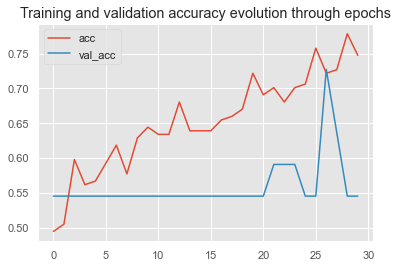

In [117]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and validation accuracy evolution through epochs')
plt.legend()
plt.show()

In [118]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 445ms/step - loss: 0.3081 - accuracy: 0.5833


[0.3080940246582031, 0.5833333730697632]